# Определение возраста покупателей

**Цель проекта:**

Постройте модель нейронной сети, которая по фотографии определит приблизительный возраст человека. Критерием качества модели должна вытупать метрика MAE, не более 8.

**Описание данных**  

В нашем распоряжении набор фотографий людей и датасет с двумя колонками (с указанием возраста): *file_name и real_age.*  

**Для выполнения проекта необходимо:**

Изучить данные:

Общая информация о выборке, количестве данных.

Провести анализ данных:

Проанализировать распределение возрастов людей изображенных на фото.
Вывести визуализацию 10-20 фото на экран  проанализировать фото визуально.  


Подготовить данных и обучение модели:  

Подготовить и получить данные ввиде батчей для обучения и тестирования модели  
Построить модель нейронной сети  
Осуществить обучение модели
Проверить качество модели

Метрика MAE модели не должна превышать 8.

## Исследовательский анализ данных

### Импорт библиотек, константы

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from PIL import Image


In [2]:
RANDOM_STATE = 158
PATH = '/datasets/faces/'

### Формирование выборки и первичный анализ

In [3]:
labels = pd.read_csv(PATH + 'labels.csv')

datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=RANDOM_STATE) 

Found 7591 validated image filenames.


In [4]:
print('Количество объектов -', datagen_flow.n)
print('Количество уникальных возрастов в таргете -', len(labels.real_age.unique()))
print('Размер изображения -', datagen_flow[0][0][0].shape)
print('Размер батчей -', datagen_flow[0][0].shape[0])
print('Количество батчей -', datagen_flow.n//datagen_flow.batch_size)

Количество объектов - 7591
Количество уникальных возрастов в таргете - 97
Размер изображения - (224, 224, 3)
Размер батчей - 32
Количество батчей - 237


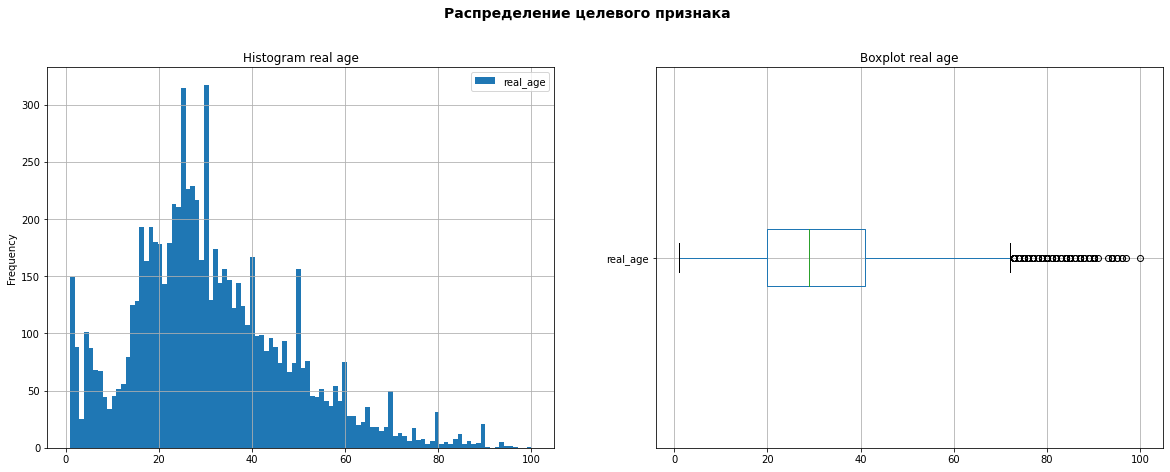

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [5]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))
fig.suptitle('Распределение целевого признака', fontsize = 14, fontweight='bold', y = 1)
labels.plot(kind='hist', bins=100, grid=True, ax=axes[0], title='Histogram real age')
labels.plot(kind='box', vert=False, grid=True, ax=axes[1], title='Boxplot real age')
plt.show()

display(labels.describe().T)

Распределение целевого признака, "скошено" влево и имеет хвост в сторону возраста 60+. На боксплоте видно, что соновное количество объектов в диапазоне 20 - 41 лет, и есть выбросы более в диапазоне более 75 лет. 

### Напечатаем изображения из датасета

In [ ]:
def name_age(x):
    age_name = 'лет'
    if x%10 == 1 and x != 11:
        age_name = 'год'
    elif x%10 in [2, 3, 4] and x not in [12, 13, 14]:
        age_name = 'года'
    return f'{x} {age_name}'

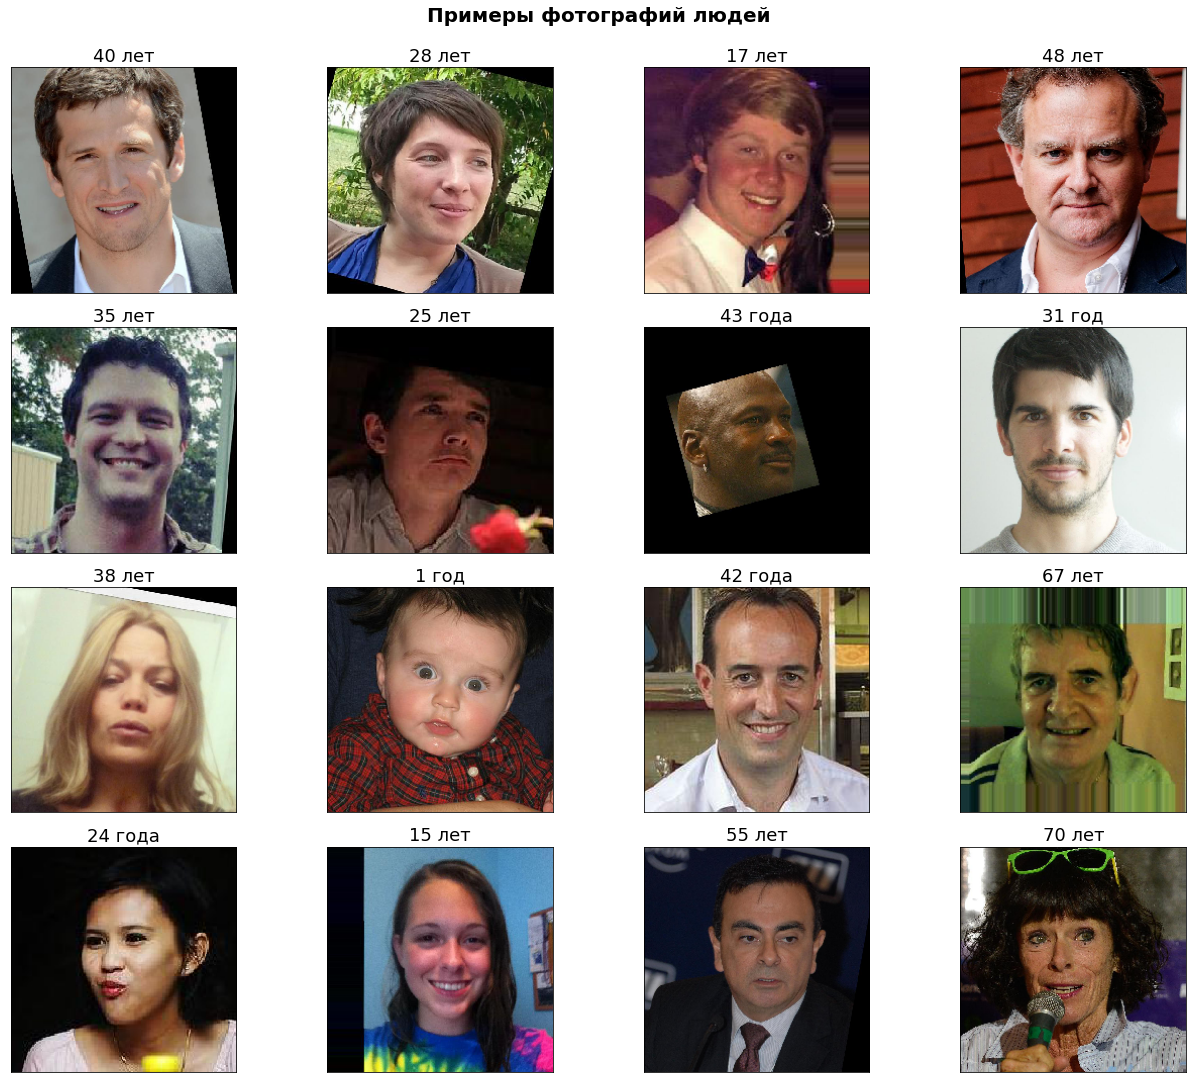

In [7]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Примеры фотографий людей', fontsize = 20, fontweight='bold', y = 1)
for i, f in enumerate(train_gen_flow[0][0][:16]):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(f)
    plt.title('{0}'.format(name_age(train_gen_flow[0][1][i])), fontdict={'fontsize': 18}) 
    plt.xticks(list())
    plt.yticks(list())
    plt.tight_layout()

На примерах фотографий видно, что они разного качества, с разными поворотами и ракурсами. некоторые фотографии обрезаны и развернуты. Так же необходимо обратить внимание, на некоторых фотограцифх сильно отличается освещение и есть фото где посторонние предметы закрывают часть лица(жвачка, микрофон и т.п). На фото люди разных национальностей и возрастов.

## Обучение модели

In [8]:
def load_train(path):
    
    labels = pd.read_csv(f'{path}/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,  horizontal_flip=True, rescale=1./255)
    
    train_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_flow

def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_flow


def create_model(input_shape):
    
    optimizer = Adam(learning_rate=0.0001)
    loss = MeanSquaredError()
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))    
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [9]:
train_data = load_train(PATH)
test_data = load_test(PATH)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [10]:
model = create_model(train_gen_flow[0][0][0].shape)
model.summary()

2023-01-20 19:06:54.149530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
#train_model(model=model, train_data=train_data, test_data=test_data)

Train for 178 steps, validate for 60 steps  

Epoch 1/10  
178/178 - 72s - loss: 262.8722 - mae: 11.4232 - val_loss: 639.8884 - val_mae: 20.3138  

Epoch 2/10  
178/178 - 51s - loss: 77.3134 - mae: 6.6418 - val_loss: 780.9603 - val_mae: 22.8453  

Epoch 3/10
178/178 - 52s - loss: 51.7502 - mae: 5.4677 - val_loss: 246.6530 - val_mae: 11.3762   

Epoch 4/10
178/178 - 48s - loss: 37.0070 - mae: 4.6334 - val_loss: 101.6502 - val_mae: 7.5984  

Epoch 5/10
178/178 - 43s - loss: 27.6344 - mae: 4.0353 - val_loss: 93.4972 - val_mae: 7.3815  

Epoch 6/10
178/178 - 61s - loss: 23.7663 - mae: 3.6893 - val_loss: 73.0869 - val_mae: 6.4497  

Epoch 7/10
178/178 - 62s - loss: 19.0306 - mae: 3.3269 - val_loss: 83.5886 - val_mae: 6.8134  

Epoch 8/10
178/178 - 48s - loss: 14.2175 - mae: 2.8758 - val_loss: 67.9285 - val_mae: 6.0691  

Epoch 9/10
178/178 - 44s - loss: 11.0562 - mae: 2.5220 - val_loss: 60.5308 - val_mae: 5.7700  

Epoch 10/10
178/178 - 38s - loss: 8.9282 - mae: 2.2510 - val_loss: 63.6615 - val_mae: 5.8211  

## Анализ обученной модели

Данное исследование было реализовано, с целью создания и обучения модели нейроной сети, для определения возраста людей по фотографии.

Входные данные - данные содержат 7591 фотографий разных людей и возраста каждого из них.

**В ходе исследования:**
- Был проанализирован датасет с возрастом людей на фотографиях, из распределение  основные статистические показатели.
- Были визуализированы и проанализироване несколько фотографий с возрастом и определены качество фотографий.
- Была подготовлена модель нейронной сети для определения возраста на основании предобученной модели `ResNet50`
- Модель была обученна предварительно подготовленных данных на 10 эпохах

**В итоге:**   
При небольшой предобработки изображений ввиде `horizontal_flip`, оптимизатора `Adam с learning_rate=0.0001` и функцией потерь `mse`, при обучении  на 10 эпохах было получена метрика `MAE` = `5.8211`.